# Laboratorio 4
#### Julio Cesar Rodas Guerra 
#### 15002024

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import joblib

### 1. Cargamos Dataset

In [2]:
data = pd.read_csv('train.csv')

print(str(data.shape) + '\n')

data.head()

(891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2. Análisis de Datos para toma de decisiones en FE Pipeline

##### 2.1 Análisis del Target


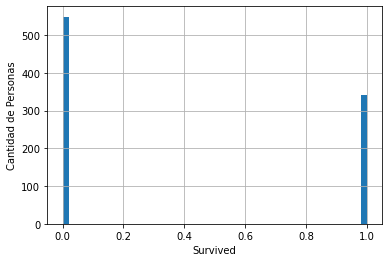

In [3]:
data['Survived'].hist(bins=50, density=False)
plt.xlabel("Survived")
plt.ylabel("Cantidad de Personas")
plt.show()

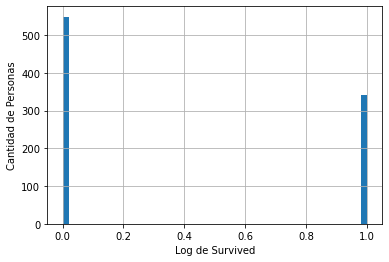

In [4]:
#transformación de target con power.
np.power(data['Survived'],3).hist(bins=50, density=False)
plt.xlabel("Log de Survived")
plt.ylabel("Cantidad de Personas")
plt.show()

#### 2.2 Verificamos tipos de variables en X

In [5]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [7]:
#cantidad de variables categóricas
len(cat_vars)

5

In [8]:
#Forzamos a todas las variables como categóticas
data[cat_vars] = data[cat_vars].astype('O')

In [9]:
#variables numéricas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'Survived')]
num_vars

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
len(num_vars)

6

#### 2.3 Análisis de Valores Faltantes

In [11]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

3

In [12]:
#proporcion de NAs en cada variable
data[var_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

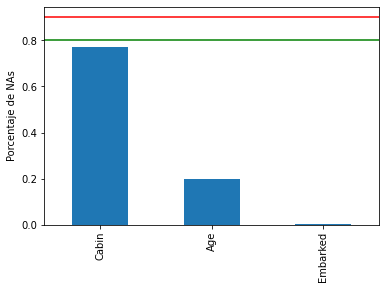

In [13]:
#graficamos porcentajes de NAs.
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.8, color="g")

In [14]:
#variables categóricas con NAs.
cat_na = [var for var in cat_vars if var in var_with_na]
cat_na

['Cabin', 'Embarked']

In [15]:
#variables numéricas con NAs.
num_na = [var for var in num_vars if var in var_with_na]
num_na

['Age']

In [16]:
print("Cantidad de variables numéricas con NAs. {}".format(len(num_na)))
print("Cantidad de variables categóticas con NAs. {}".format(len(cat_na)))

Cantidad de variables numéricas con NAs. 1
Cantidad de variables categóticas con NAs. 2


#### 2.3.1 Verificación del impacto del NA contra el Target (Survived)

In [17]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

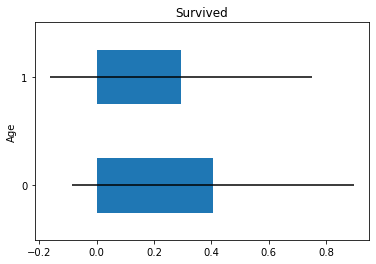

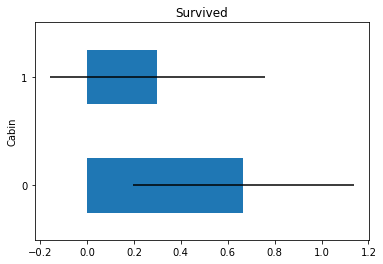

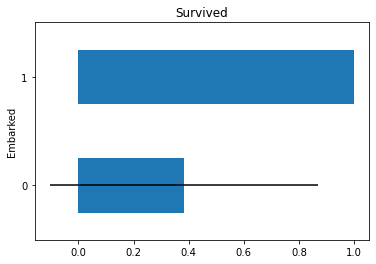

In [18]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

2.4 No sé realiza el Análisis de Variables Temporales porque el dataset no contiene fechas.

## 2.5 Variables Discretas

In [19]:
discrete_vars = [var for var in num_vars if(len(data[var].unique()) < 20)]
discrete_vars

['Pclass', 'SibSp', 'Parch']

In [20]:
print("Cantidad de Variables Discretas: ", len(discrete_vars))

Cantidad de Variables Discretas:  3


In [21]:
data[discrete_vars].head()

,Pclass,SibSp,Parch
0,3,1,0
1,1,1,0
2,3,0,0
3,1,1,0
4,3,0,0


In [22]:
import seaborn as sns

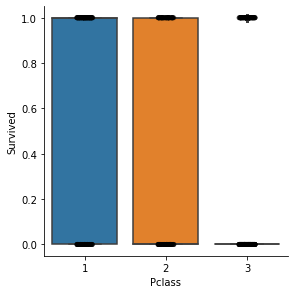

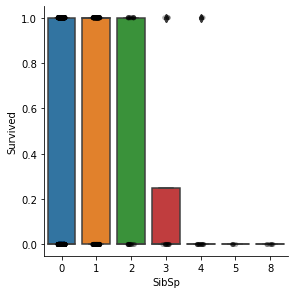

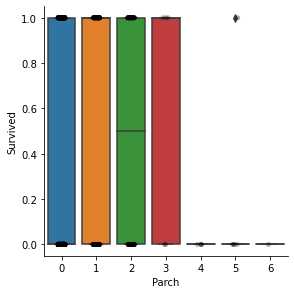

In [23]:
for var in discrete_vars:
    sns.catplot(x=var, y = 'Survived', data=data, kind="box", height=4)
    sns.stripplot(x=var, y='Survived', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

## 2.6 Variables Continuas

In [24]:
cont_vars = [var for var in num_vars if var not in discrete_vars]

In [25]:
print("Variables Numericas Continuas: ", len(cont_vars))

Variables Numericas Continuas:  3


In [26]:
data[cont_vars].head()

,PassengerId,Age,Fare
0,1,22.0,7.2500
1,2,38.0,71.2833
2,3,26.0,7.9250
3,4,35.0,53.1000
4,5,35.0,8.0500


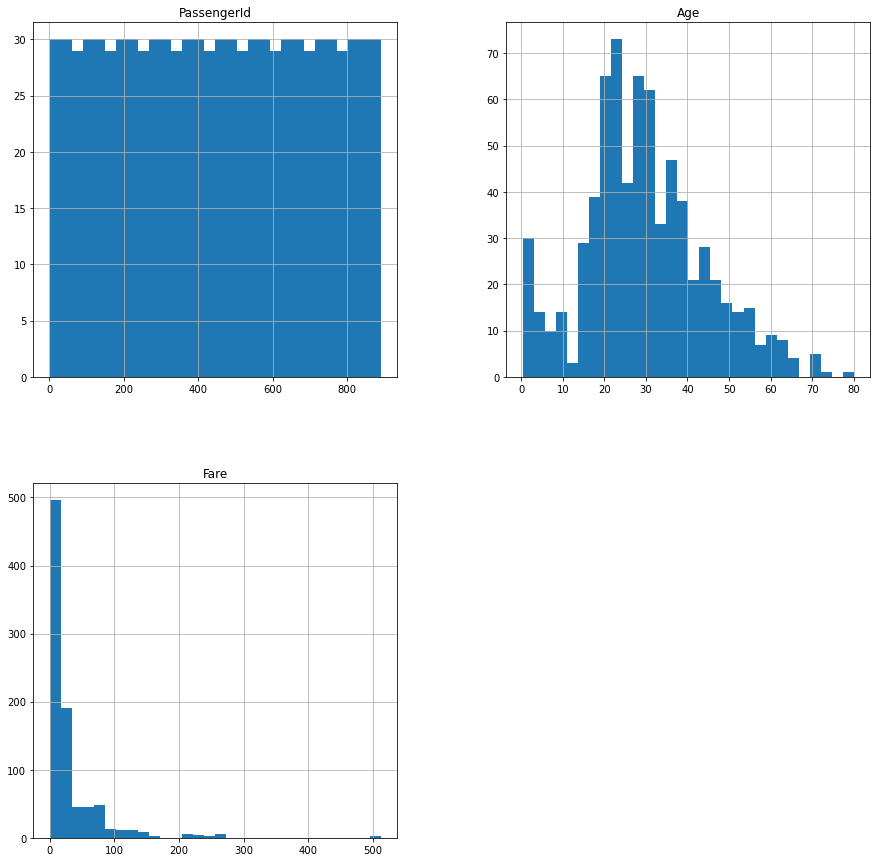

In [27]:
data[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [28]:
sesgadas = ['Fare']

In [29]:
cont_vars = [var for var in cont_vars if var not in sesgadas]

In [30]:
cont_vars

['PassengerId', 'Age']

#### Transformación de Yeo-Johnson

In [31]:
import scipy.stats as stats

In [32]:
temp_yj = data.copy()

In [33]:
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

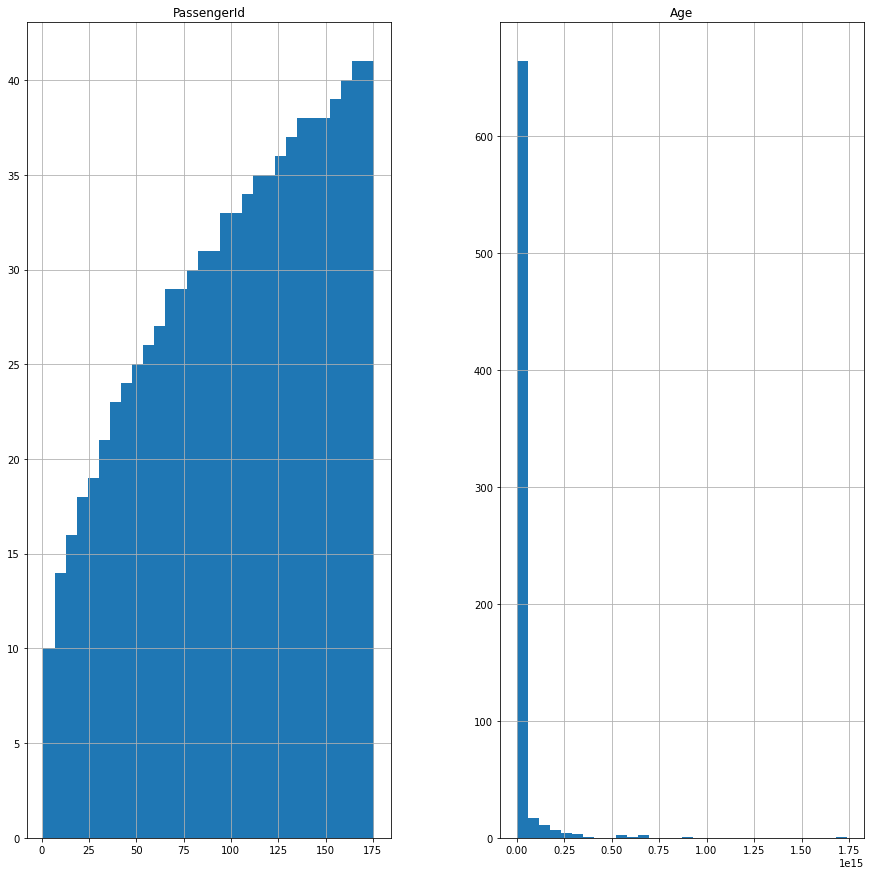

In [34]:
temp_yj[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [35]:
len(cont_vars)

2

In [36]:
cont_specials = ['PassengerId', 'Age']

In [37]:
temp = data.copy()

for var in cont_vars:
    temp[var] = np.log(data[var] + 1)

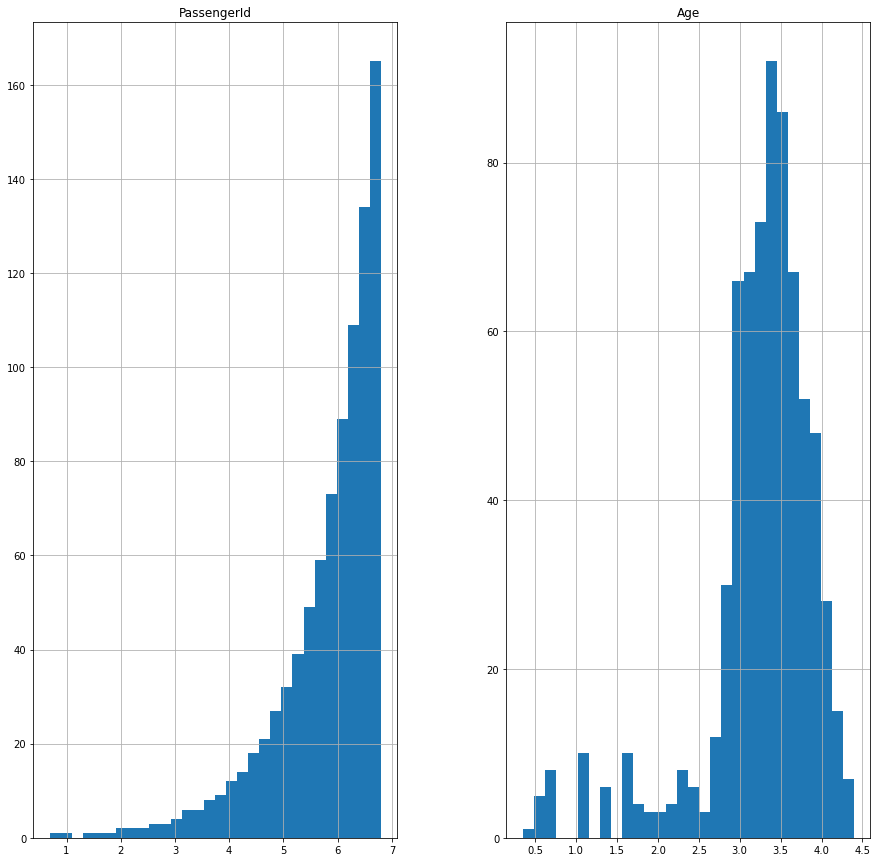

In [38]:
temp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

C:\Users\kimbe\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


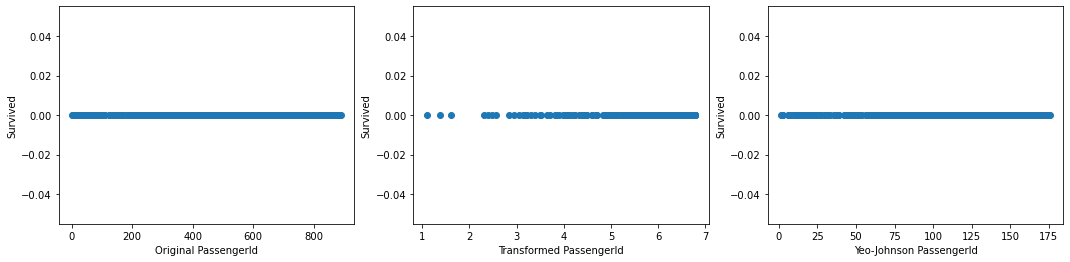

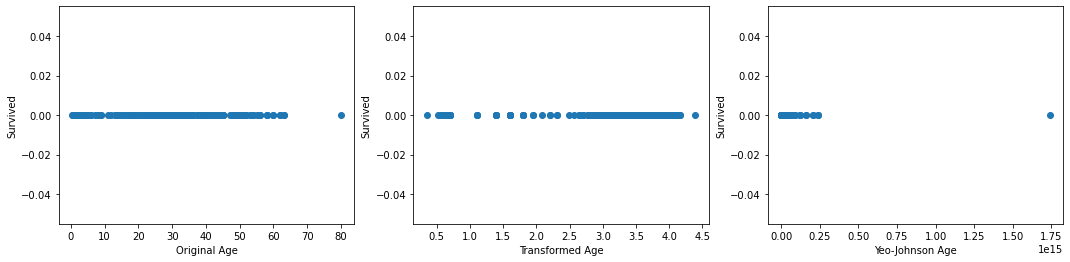

In [39]:
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Original " + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp[var], np.log(data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Transformed " + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], np.log(data['Survived']))
    plt.ylabel("Survived")
    plt.xlabel("Yeo-Johnson " + var)

    plt.show()

### 2.6.1 Variables con Sesgo

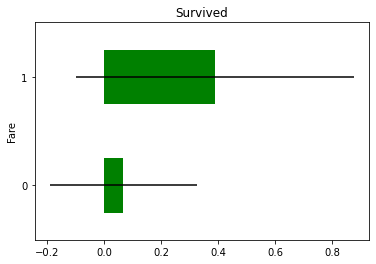

In [40]:
for var in sesgadas:
    temp = data.copy()
    
    temp[var] = np.where(data[var] == 0, 0, 1)
    
    temp = temp.groupby(var)['Survived'].agg(['mean', 'std'])
    
    temp.plot(kind='barh', y="mean", legend=False, xerr="std", title = "Survived", color="green")
    plt.show()

## 2.7 Variables Categóricas

In [41]:
len(cat_vars)

5

In [42]:
data[cat_vars].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


<AxesSubplot:>

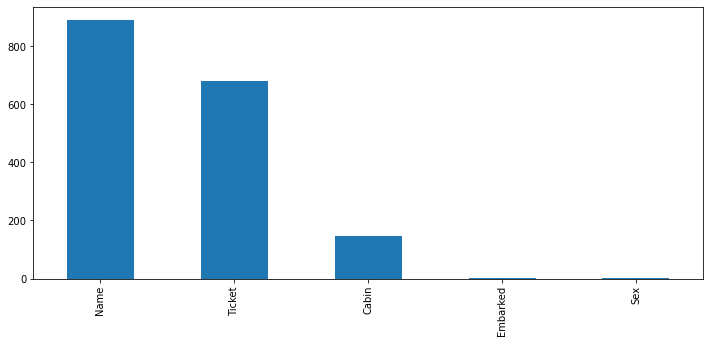

In [43]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [44]:
np.unique(data['Name'])

array(['Abbing, Mr. Anthony', 'Abbott, Mr. Rossmore Edward',
       'Abbott, Mrs. Stanton (Rosa Hunt)', 'Abelson, Mr. Samuel',
       'Abelson, Mrs. Samuel (Hannah Wizosky)',
       'Adahl, Mr. Mauritz Nils Martin', 'Adams, Mr. John',
       'Ahlin, Mrs. Johan (Johanna Persdotter Larsson)',
       'Aks, Mrs. Sam (Leah Rosen)', 'Albimona, Mr. Nassef Cassem',
       'Alexander, Mr. William', 'Alhomaki, Mr. Ilmari Rudolf',
       'Ali, Mr. Ahmed', 'Ali, Mr. William',
       'Allen, Miss. Elisabeth Walton', 'Allen, Mr. William Henry',
       'Allison, Master. Hudson Trevor', 'Allison, Miss. Helen Loraine',
       'Allison, Mrs. Hudson J C (Bessie Waldo Daniels)',
       'Allum, Mr. Owen George',
       'Andersen-Jensen, Miss. Carla Christine Nielsine',
       'Anderson, Mr. Harry', 'Andersson, Master. Sigvard Harald Elias',
       'Andersson, Miss. Ebba Iris Alfrida',
       'Andersson, Miss. Ellis Anna Maria',
       'Andersson, Miss. Erna Alexandra',
       'Andersson, Miss. Ingeborg Con

In [45]:
np.unique(data['Ticket'])

array(['110152', '110413', '110465', '110564', '110813', '111240',
       '111320', '111361', '111369', '111426', '111427', '111428',
       '112050', '112052', '112053', '112058', '112059', '112277',
       '112379', '113028', '113043', '113050', '113051', '113055',
       '113056', '113059', '113501', '113503', '113505', '113509',
       '113510', '113514', '113572', '113760', '113767', '113773',
       '113776', '113781', '113783', '113784', '113786', '113787',
       '113788', '113789', '113792', '113794', '113796', '113798',
       '113800', '113803', '113804', '113806', '113807', '11668', '11751',
       '11752', '11753', '11755', '11765', '11767', '11769', '11771',
       '11774', '11813', '11967', '12233', '12460', '12749', '13049',
       '13213', '13214', '13502', '13507', '13509', '13567', '13568',
       '14311', '14312', '14313', '14973', '1601', '16966', '16988',
       '17421', '17453', '17463', '17464', '17465', '17466', '17474',
       '17764', '19877', '19928', '19943

In [46]:
##np.unique(data['Cabin'])

In [47]:
##np.unique(data['Embarked'])

In [48]:
np.unique(data['Sex'])

array(['female', 'male'], dtype=object)

No se tienen variables que contengan las mismas opciones.

## 2.7 Rare Labels:

In [49]:
def analyse_rare_labels(df, var, rare_perc):
    temp = df.groupby(var)['Survived'].count()/len(df)
    
    return temp[temp < rare_perc]

In [50]:
for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

Name
Abbing, Mr. Anthony                      0.001122
Abbott, Mr. Rossmore Edward              0.001122
Abbott, Mrs. Stanton (Rosa Hunt)         0.001122
Abelson, Mr. Samuel                      0.001122
Abelson, Mrs. Samuel (Hannah Wizosky)    0.001122
                                           ...   
de Mulder, Mr. Theodore                  0.001122
de Pelsmaeker, Mr. Alfons                0.001122
del Carlo, Mr. Sebastiano                0.001122
van Billiard, Mr. Austin Blyler          0.001122
van Melkebeke, Mr. Philemon              0.001122
Name: Survived, Length: 891, dtype: float64

Series([], Name: Survived, dtype: float64)

Ticket
110152         0.003367
110413         0.003367
110465         0.002245
110564         0.001122
110813         0.001122
                 ...   
W./C. 6608     0.004489
W./C. 6609     0.001122
W.E.P. 5734    0.001122
W/C 14208      0.001122
WE/P 5735      0.002245
Name: Survived, Length: 681, dtype: float64

Cabin
A10    0.001122
A14    0.001122
A1

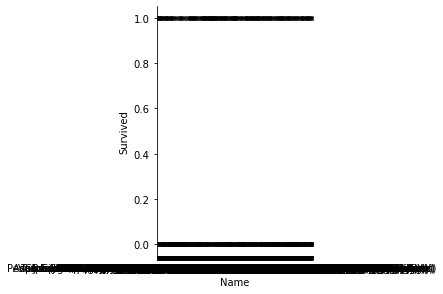

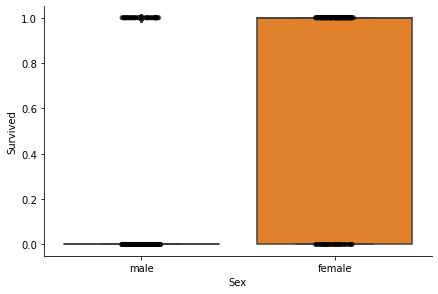

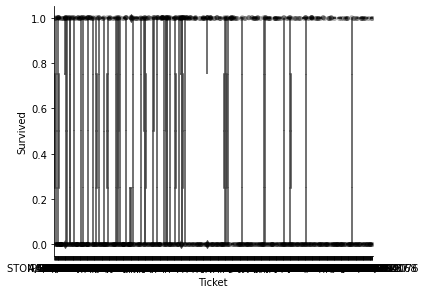

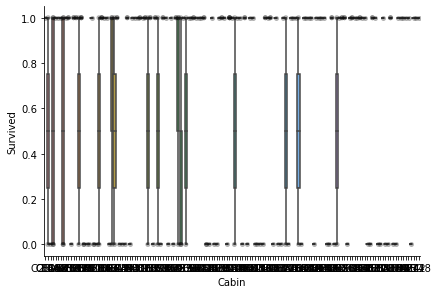

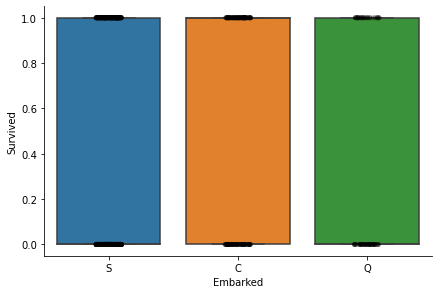

In [51]:
for var in cat_vars:
    sns.catplot(x=var, y = 'Survived', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='Survived', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

In [52]:
pd.pandas.set_option('display.max_columns', None) #habilitamos despliegue maximo de columnas

In [53]:
data = pd.read_csv('train.csv')
print(data.shape)

(891, 12)


In [54]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
#separamos data para entrenamiento y prueba,
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['Survived'], axis=1),
                        data['Survived'],
                        test_size=0.15,
                        random_state=2021)

In [56]:
X_train.shape, X_test.shape

((757, 11), (134, 11))

### 2. Missing Values

In [57]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars

In [58]:
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

In [59]:
len(cat_vars)

5

##### 2.1.1 Detección de NaN en variables categórias

In [60]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]

In [61]:
cat_vars_with_na

['Cabin', 'Embarked']

In [62]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Cabin       0.764861
Embarked    0.001321
dtype: float64

In [63]:
#variables tratadas con etiqueta de faltante por cantidad masiva de faltantes.
vars_with_missing_string = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() > 0.2]

#variables tratadas con procedimiento por candiad adecuada de faltantes.
vars_freq_category = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() <= 0.2]

In [64]:
vars_with_missing_string

['Cabin']

In [65]:
vars_freq_category

['Embarked']

##### Aplicamos criterio para tratar data faltante

In [66]:
#Faltantes con etiqueta missing
X_train[vars_with_missing_string] = X_train[vars_with_missing_string].fillna('Missing')
X_test[vars_with_missing_string] = X_test[vars_with_missing_string].fillna('Missing')

In [67]:
for var in vars_freq_category:
    mode = X_train[var].mode()[0]
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)
    
    print(var, "-------", mode)

Embarked ------- S


In [68]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Embarked    0.0
Cabin       0.0
dtype: float64

In [69]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]
cat_vars_with_na

[]

##### 2.2 Missing Values para Variables Numéricas

In [70]:
num_vars = [var for var in X_train.columns
               if var not in cat_vars and var != 'Survived']

In [71]:
len(num_vars)

6

In [72]:
##Numéricas con faltantes
num_vars_with_na = [var for var in num_vars
                       if X_train[var].isnull().sum() > 0]



In [73]:
X_train[num_vars_with_na].isnull().mean()

Age    0.200793
dtype: float64

##### Aplicamos criterio para tratar data faltante

In [74]:
for var in num_vars_with_na:
    mean_val = X_train[var].mean()
    
    print(var, mean_val)
    
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)
    

Age 29.51267768595041


In [75]:
X_train[num_vars_with_na].isnull().mean()

Age    0.0
dtype: float64

### 4. Transformación de Variables Numéricas

In [76]:
#aplicamos transformación de Yeo-Jonhson
X_train['Age'], param = stats.yeojohnson(X_train['Age'])

In [77]:
X_test['Age'] = stats.yeojohnson(X_test['Age'], lmbda=param)

In [78]:
print(param)

0.810604376712183


#### 4.1 Binarización de Variables con Sesgo fuerte

In [79]:
sesgadas = ['Fare']

In [80]:
for var in sesgadas:
    X_train[var] = np.where(X_train[var] == 0, 0, 1)
    X_test[var] = np.where(X_test[var] == 0, 0, 1)

### 5. Codificación de Variables Categóricas
No aplica en este dataset

#### 5.1 Codificación de Raras (baja frecuencia)

In [82]:
other_cat = [var for var in cat_vars]
other_cat

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [83]:
len(other_cat)

5

In [84]:
#funcion para encontar etiquetas raras
def find_rare_labels_freq(df, var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [85]:
for var in other_cat:
    freqValue = find_rare_labels_freq(X_train, var, 0.01)
    
    #print(var, '--------', freqValue)
    
    X_train[var] = np.where(X_train[var].isin(freqValue), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freqValue), X_test[var], 'Rare')

In [86]:
def replace_category_vals(train, test, y_train, var, target):
    
    temp = pd.concat([train, y_train], axis=1) 
    order_labels = temp.groupby([var])[target].mean().sort_values().index
    
    ordinal_values = {k: i for i, k in enumerate(order_labels, 0)}
    
    print(var, ordinal_values)
    
    train[var] = train[var].map(ordinal_values)
    test[var] = test[var].map(ordinal_values)
    

In [87]:
for var in other_cat:
    replace_category_vals(X_train, X_test, y_train, var, 'Survived')

Name {'Rare': 0}
Sex {'male': 0, 'female': 1}
Ticket {'Rare': 0}
Cabin {'Missing': 0, 'Rare': 1}
Embarked {'S': 0, 'Q': 1, 'C': 2}


In [88]:
def analyse_other_cats(train, y_train, var):
    temp = pd.concat([train, y_train], axis=1)

    temp.groupby(var)['Survived'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Survived')
    plt.show()

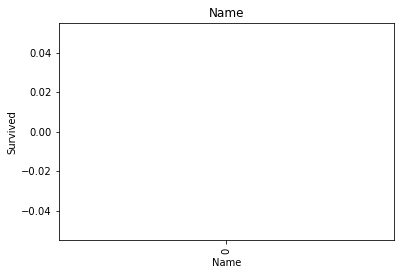

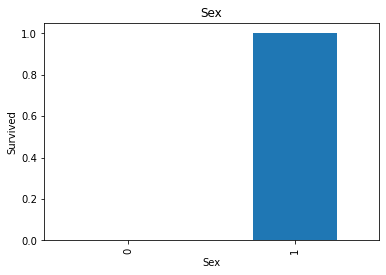

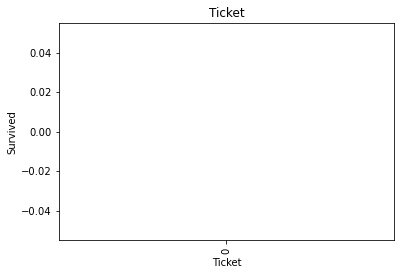

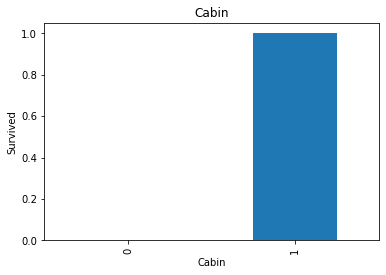

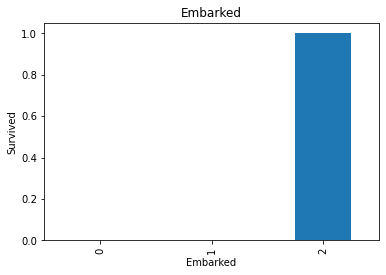

In [89]:
for var in other_cat:
    analyse_other_cats(X_train, y_train, var)

### 6. Feature Scaling

In [90]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

In [91]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.961798,0.0,0.0,1.0,0.617724,0.125,0.166667,0.0,1.0,0.0,0.0
1,0.769663,0.5,0.0,0.0,0.374482,0.125,0.333333,0.0,1.0,0.0,1.0
2,0.106742,1.0,0.0,0.0,0.431785,0.000,0.000000,0.0,1.0,0.0,0.0
3,0.470787,1.0,0.0,1.0,0.166795,0.000,0.333333,0.0,1.0,0.0,0.0
4,0.233708,1.0,0.0,1.0,0.253955,0.000,0.000000,0.0,1.0,0.0,0.5


In [92]:
#Guardamos dataset con data preparada para entrenamiento.

X_train.to_csv('preprocess_data/prep_Xtrain.csv', index=False)
X_test.to_csv('preprocess_data/prep_Xtest.csv', index=False)

y_train.to_csv('preprocess_data/prep_ytrain.csv', index=False)
y_test.to_csv('preprocess_data/prep_ytest.csv', index=False)

In [93]:
joblib.dump(scaler, 'preprocess_data/minmax_scaler.joblib')

['preprocess_data/minmax_scaler.joblib']

In [94]:
np.sum(X_train[X_train == 'Unf'].sum(axis=0))

0.0

In [179]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

### 3. Selección de Variables

In [180]:
X_train = pd.read_csv("preprocess_data/prep_Xtrain.csv")
X_test = pd.read_csv("preprocess_data/prep_Xtest.csv")

In [181]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0.961798,0.0,0.0,1.0,0.617724,0.125,0.166667,0.0,1.0,0.0,0.0
1,0.769663,0.5,0.0,0.0,0.374482,0.125,0.333333,0.0,1.0,0.0,1.0
2,0.106742,1.0,0.0,0.0,0.431785,0.000,0.000000,0.0,1.0,0.0,0.0
3,0.470787,1.0,0.0,1.0,0.166795,0.000,0.333333,0.0,1.0,0.0,0.0
4,0.233708,1.0,0.0,1.0,0.253955,0.000,0.000000,0.0,1.0,0.0,0.5


In [182]:
y_train = pd.read_csv("preprocess_data/prep_ytrain.csv")
y_test = pd.read_csv("preprocess_data/prep_ytest.csv")

y_train.head()

,Survived
0,1
1,0
2,0
3,0
4,1


In [183]:
#objeto selector de variables
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [184]:
sel_.get_support().sum()

9

In [185]:
sel_.get_support()

array([ True,  True, False,  True,  True,  True,  True, False,  True,
        True,  True])

In [186]:
selected_features = X_train.columns[(sel_.get_support())]

In [187]:
selected_features

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')

In [188]:
pd.Series(selected_features).to_csv('preprocess_data/selected_features.csv', index=False)

### 4. Entrenamiento del Modelo

In [189]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [190]:
linear_model = Lasso(alpha=0.001, random_state=2022)

linear_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=2022)

#### Predicciones

In [191]:
from sklearn.metrics import mean_squared_error, r2_score

In [192]:
preds_train = linear_model.predict(X_train)

In [193]:
#Resultados del Train
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), np.exp(preds_train))))

print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), 
                                                           np.exp(preds_train), squared=False)))

print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_train), np.exp(preds_train))))

MSE de Entrenamiento: 0.40670334078767895
RMSE de Entrenamiento: 0.6377329698139175
R2 de Entrenamiento: 0.4171378877314772


In [194]:
preds_test = linear_model.predict(X_test)

In [195]:
#Resultados del Test
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), np.exp(preds_test))))

print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), 
                                                           np.exp(preds_test), squared=False)))

print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_test), np.exp(preds_test))))

MSE de Entrenamiento: 0.5759175570439363
RMSE de Entrenamiento: 0.7588923224304858
R2 de Entrenamiento: 0.1785825502989511


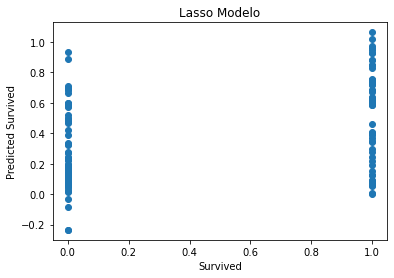

In [196]:
plt.scatter(y_test, preds_test)
plt.xlabel("Survived")
plt.ylabel("Predicted Survived")
plt.title("Lasso Modelo")
plt.show()

In [197]:
importance = pd.Series(np.abs(linear_model.coef_.ravel()))
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)

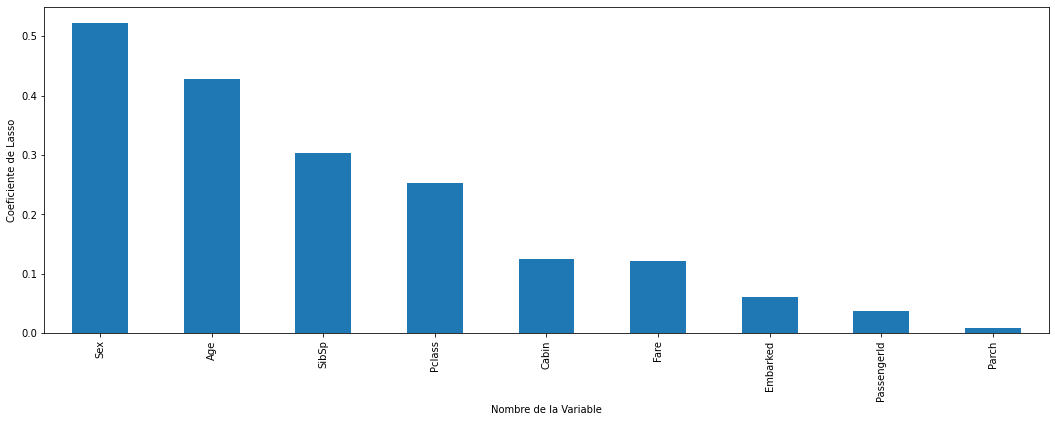

In [198]:
importance.plot.bar(figsize=(18, 6))
plt.ylabel("Coeficiente de Lasso")
plt.xlabel("Nombre de la Variable")
plt.show()

In [199]:
import joblib

In [200]:
joblib.dump(linear_model, 'final_model/titanic_model.joblib')

['final_model/titanic_model.joblib']

In [201]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import joblib

In [202]:
data = pd.read_csv("train.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [203]:
X_train, X_test, y_train, y_test = train_test_split(
        data.drop(['Survived'], axis=1),
        data['Survived'],
        test_size=0.1,
        random_state=2022)

X_train.shape, X_test.shape

((801, 11), (90, 11))

## Configuración del Machine Learning Pipeline

In [204]:
#Variables categoricas con NA
CATEGORICAL_VARS_WITH_NA_FREQUENT = []

#Variable categoricas con NA pero indicador de Missing
CATEGORICAL_VARS_WITH_NA_MISSING = []


#Variables numéricas con NA
NUMERICAL_VARS_WITH_NA = ['Age']


#Variables para binarización por sesgo fuerte
BINARIZE_VARS = ['Fare']

#Variables categoricas a codificar sin ordinalidad
CATEGORICAL_VARS = ['Sex', 'Ticket']

#Variables seleccionadas según análisis de Lasso
FEATURES = [
    'PassengerId',  
    'Pclass',
    'Sex',  
    'Age', 
    'SibSp', 
    'Parch', 
    'Ticket', 
    'Fare',
]

In [205]:
#Selección de variables para entrenamiento
X_train = X_train[FEATURES]

In [206]:
#Seleccionamos variables para predicción
X_test = X_test[FEATURES]

## Machine Learning PipeLine

In [207]:
Titanic_pipeline = Pipeline([
    
    #============= IMPUTACIONES ===================#
    
    #1. Imputación de varaibles categoricas
    ('missing_imputation', 
         CategoricalImputer(imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)
    ),
    
    #2. Imputación de variables categoricas con NA basado en frequiencia.
    ('frequent_imputation', 
         CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)
    ),
    
    #3. Indicamos Faltante en variables numéricas para imputar
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),
    
    #4. Imputación de mediana para variables categoricas
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),
   
    #8. Binarización de Variables con Sesgo Fuerte
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)
    ),
    
    #============ CODIFICACION DE VARIABLES CATEGORICAS NOMINALES ============
    
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS)),
    
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    #=========== SCALER ==============
    ('scaler', MinMaxScaler()),
    
    #=========== ENTRENAMIENTO DEL MODELO ============
    ('Lasso', Lasso(alpha=0.01, random_state=2022)),
]) 

In [208]:
Titanic_pipeline.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation', CategoricalImputer(variables=[])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=[])),
                ('missing_indicator', AddMissingIndicator(variables=['Age'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['Age'])),
                ('binarizer',
                 SklearnTransformerWrapper(transformer=Binarizer(threshold=0),
                                           variables=['Fare'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['Sex', 'Ticket'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Sex', 'Ticket'])),
                ('scaler', MinMaxScaler()),
                ('Lasso', Lasso(alpha=0.01, random_

In [209]:
preds = Titanic_pipeline.predict(X_test)

In [210]:
from sklearn.metrics import mean_squared_error 

In [211]:
mean_squared_error(np.exp(y_test), np.exp(preds), squared=False)

0.577799083793835

In [212]:
#Guardamos pipeline
joblib.dump(Titanic_pipeline, 'Titanic_pipeline.pkl')

['Titanic_pipeline.pkl']